# Setup

**Imports**

In [64]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from scipy.signal import chirp, stft, sweep_poly
from ruptures.base import BaseCost

rng = np.random.default_rng()

**Utility functions**

In [65]:
class MultivariateNormalCost(BaseCost):

    """Custom cost for piecewise Poisson signals."""

    # The 2 following attributes must be specified for compatibility.
    model = "Poisson"
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self

    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        subsignal = self.signal[start:end]
        cov_mat = np.cov(subsignal.T)
        _, val = np.linalg.slogdet(cov_mat)
        return (end-start)*val

In [94]:
tones = {"1": (697, 1209), "2": (697, 1336), "3": (697, 1477), "4": (770, 1209), "5": (770, 1336), "6": (770, 1477), "7": (852, 1209), "8": (852, 1336), "9": (852, 1477), "0": (941, 1336), "*": (941, 1209), "#": (941, 1477), "A": (697, 1633), "B": (770, 1633), "C": (852, 1633), "D": (941, 1633)}
FS = 22_050  # Hz
sigma = 2


def generate_symbol(symbol, duration, fs):
    """Generate the sound for number with given duration"""
    # get both frequencies for the symbol
    f1, f2 = tones[symbol]
    # time array
    time_arr = np.arange(0, duration, 1 / fs)
    # audio signal
    signal = np.cos(2 * np.pi * f1 * time_arr) + np.cos(2 * np.pi * f2 * time_arr)
    return signal

def generate_signal():
    n_symbols = rng.integers(3, 12)
    list_of_symbols = rng.choice(list("1234567890*#ABCD"), size=n_symbols)

    list_of_segments = list()

    for symbol in list_of_symbols:
        duration = rng.uniform(low=0.05, high=0.2)  # seconds
        # generate tone
        symbol_signal = generate_symbol(symbol=symbol, duration=duration, fs=FS)
        # generate silence
        silence = np.zeros(int(duration*FS))
        # append tone and silence
        list_of_segments.extend([symbol_signal, silence])

    # silence at the start
    silence = np.zeros(int(duration*FS))
    list_of_segments = [silence] + list_of_segments

    signal = np.concatenate(list_of_segments)
    n_samples = signal.shape[0]
    time_array = np.arange(n_samples) / FS
    
    # add nuissance
    inst_freq = np.sin(2 * np.pi * 1.2 * time_array) * 1500 + 2000
    poly = np.polyfit(x=time_array, y=inst_freq, deg=14)
    sin_freq = sweep_poly(time_array, poly)
    signal += sin_freq
    # add white noise
    signal += rng.normal(scale=sigma, size=n_samples)

    return signal, list_of_symbols.tolist()


# Question 1


[Dual-tone multi-frequency signaling](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling) is a procedure to encode symbols using audio signal.

A symbold is represented by a sum of cosine waves: for $t=0,1,\dots,T-1$,

$$
y_t = \cos(2\pi f_1 t/f_s) + \cos(2\pi f_2 t/f_s)
$$
where each combination of $(f_1, f_2)$ represents a symbols (see table below).


|         | 1209 Hz  | 1336 Hz  | 1477 Hz  | 1633 Hz  |
|---------|----------|----------|----------|----------|
| **697 Hz**  | 1        | 2        | 3        | A        |
| **770 Hz**  | 4        | 5        | 6        | B        |
| **852 Hz**  | 7        | 8        | 9        | C        |
| **941 Hz**  | *        | 0        | #        | D        |

In [95]:
signal, symbols = generate_signal()
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

8 8 * 6 2 5 D


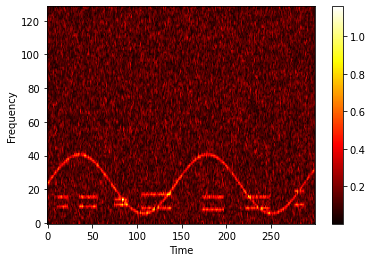

In [96]:
from scipy.signal import stft

f, t, Zxx = stft(signal, FS, nperseg=256)

plt.figure()
plt.imshow(np.abs(Zxx), aspect='auto', cmap='hot', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

In [97]:
signal_freq = np.abs(Zxx.T)
predicted_bkps = rpt.Dynp(jump=10, min_size=10, model="l2", custom_cost=MultivariateNormalCost()).fit_predict(signal=signal_freq, n_bkps=14)
predicted_bkps

[20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]

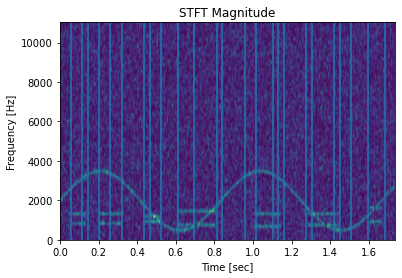

In [104]:
#pen_manual = 2 * np.log(len(signal_freq)) * np.var(signal_freq)
# 2*np.log(signal_freq.shape[0])
algo = rpt.Pelt(jump=5, min_size=1, model="l2").fit(signal=signal_freq)
predicted_bkps = algo.predict(pen=1.5)

plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

for b in predicted_bkps[:-1]:
    plt.axvline(t[b])

In [ ]:
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

for b in predicted_bkps[:-1]:
    plt.axvline(t[b])

# Question 2

In [5]:
sound_1 = np.loadtxt("signal_1.csv")
sound_2 = np.loadtxt("signal_2.csv")

# Question 3

In [24]:
lambda_n = 12
M = 9 #number of scales

In [25]:
R_array = np.array([1,3,5])
a_array = lambda_n/ ( M+1-R_array)

In [46]:
def g_u_lamda(lamda,a,R):
    if lamda >= -R*a and lamda< 0:
        arg = 2*np.pi*( lamda/(a*R) + 1/2 )
        return (1/2)*( 1+np.cos(arg))
    else : 
        return 0
    

In [47]:
#m va de 1 à M 

In [48]:
X = np.arange(0,lambda_n, lambda_n/100)

In [52]:
kernel = []
for i,r in enumerate(R_array):
    kernel.append([g_u_lamda(x-5*a_array[i],a_array[i],r) for x in X])

In [53]:
c=['blue', 'red', 'black']

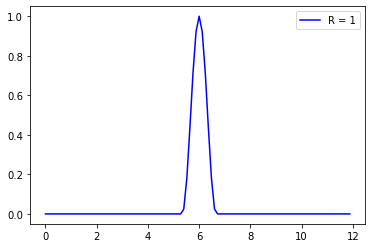

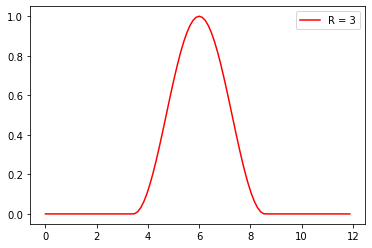

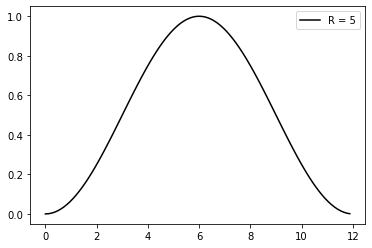

In [54]:
for _iter in range(len(kernel)):
    plt.plot(X,kernel[_iter], color = c[_iter], label = "R = "+str(R_array[_iter]))
    plt.legend()
    plt.show()

# Question 4

# Question 5

# Question 6

# Question 7